# Predicting Customer Churn with Machine Learning 🏦💰

<br>

**Table of Contents**

- [Introduction](#Introduction)
- [Libraries](#Libraries)
- [Default Parameters](#Default-Parameters)
- [A Quick Look at our Data](#A-Quick-Look-at-our-Data)
- [Creating a Test Set](#Creating-a-Test-Set)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Target Variable: Exited](#Target-Variable:-Exited)
- [Data Preprocessing](#Data-Preprocessing)
    - [Feature Selection](#Feature-Selection) <br>
    - [Encoding Categorical Features](#Encoding-Categorical-Features) <br>
    - [Scaling](#Scaling) <br>
    - [Addressing Class Imbalance](#Addressing-Class-Imbalance) 
- [Building Machine Learning Models](#Building-Machine-Learning-Models)
    - [Baseline Models](#Baseline-Models) <br>
    - [Model Tuning](#Model-Tuning) <br>
- [Results](#Results)
- [Evaluating the Test Set](#Evaluating-the-Test-Set)
- [Bibliography](#Bibliography)
- [Conclusions](#Conclusions)


<br>

# Introduction

<br>

# Libraries

In [1]:
# Data Handling and Analysis
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chi2_contingency

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import scikitplot as skplt

<br>

# Default Parameters

In [2]:
pd.set_option('precision', 3)

%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']

random_state = 0

In [3]:
scoring_metric = 'roc_auc'

<br>

# A Quick Look at our Data

We start by importing the dataset as a Pandas DataFrame. We can also take a look at the top five rows using the `head()` method:

In [4]:
df = pd.read_csv('Data\Dataset.csv')

print('Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
print('Top five rows:')
df.head()

Dataset Imported Successfully!

It contains 10000 rows and 14 columns.
Top five rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our DataFrame has 14 features/attributes and 10K customers/instances. The last feature, '**Exited**', is the **target variable** and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

In [5]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

The `info()` method can give us valuable information such as the number of non-null values and the type of each feature:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Thankfully, there are **no missing values** in our DataFrame. The `describe()` method gives us a statistical summary of the numerical features:

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.529,96.653,350.00,584.00,652.000,718.000,850.00
Age,10000.0,38.922,10.488,18.00,32.00,37.000,44.000,92.00
Tenure,10000.0,5.013,2.892,0.00,3.00,5.000,7.000,10.00
Balance,10000.0,76485.889,62397.405,0.00,0.00,97198.540,127644.240,250898.09
NumOfProducts,10000.0,1.530,0.582,1.00,1.00,1.000,2.000,4.00
HasCrCard,10000.0,0.706,0.456,0.00,0.00,1.000,1.000,1.00
IsActiveMember,10000.0,0.515,0.500,0.00,0.00,1.000,1.000,1.00
EstimatedSalary,10000.0,100090.240,57510.493,11.58,51002.11,100193.915,149388.247,199992.48
Exited,10000.0,0.204,0.403,0.00,0.00,0.000,0.000,1.00


The most important things to note are:

- The age of customers ranges from 18 to 92, with a mean value approximately equal to 40.
- The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3).
- Approximately 50% of customers are active.

EDA will help us understand our dataset better. However, before we look at the data further, we need to create a **test set**, put it aside, and use it only to evaluate our Machine Learning models. This practice protects our models from **data snooping bias** (you can read more on page 51 of Ref. [[1](#Bibliography)]) and ensures that evaluation will be performed using unseen data. 

<br>

# Creating a Test Set

We will split our dataset into a train and a test set using scikit-learn's `StratifiedShuffleSplit()` function, which implements **stratified sampling**. In this method, the population is divided into homogeneous subgroups called *strata*, and the right number of instances are sampled from each stratum to guaranτee that the test set is representative of the overall population ([[1](#Bibliography)]).

In [8]:
split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.2,
                               random_state=random_state)

for train_index, test_index in split.split(df, df['Exited']):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]

<br>

# Exploratory Data Analysis

## Target Variable: Exited

As we mentioned earlier, the target variable is already encoded and can take two possible values:

- Zero (0) for a customer that has **not** churned, and
- One (1) for a customer that has churned.

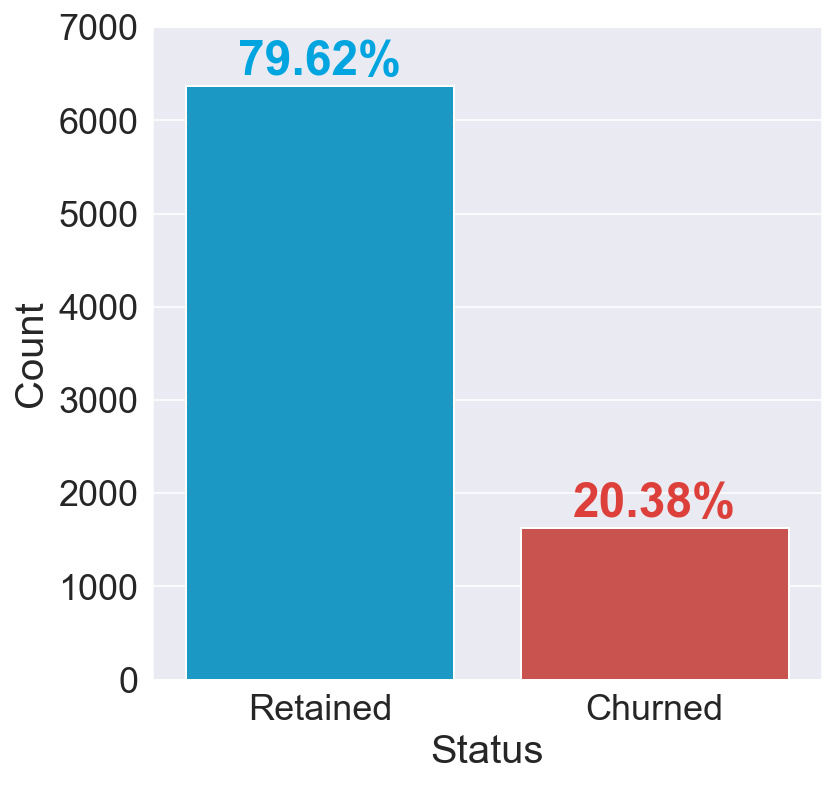

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 4)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000]);

The bank kept 80% of its clientele.

Notice that our dataset is **skewed/imbalanced** since the number of instances in the 'Retained' class outnumbers the number of instances in the 'Churned' class by a factor of 4. Therefore, we need to factor in class imbalance before building any models.

Different visualisation techniques apply to different types of variables, so it is helpful to differentiate between continuous and categorical variables and look at them separately.

In [10]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


<br>

# Data Preprocessing

<br>

## Feature Selection

<br>

## Encoding Categorical Features

<br>

## Scaling

<br>

## Addressing Class Imbalance

<br>

# Building Machine Learning Models

<br> 

## Baseline Models

<br>

## Model Tuning

<br>

# Results

<br>

# Evaluating the Test Set

<br>

# Bibliography

<br>

# Conclusions